<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Pipeline containing data filtering and outlier detection</strong>
</div>

In [13]:
import os
import sys
sys.path.append(os.path.abspath(".."))

from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import psycopg2

import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from data_pipeline.EntryDataCleaning import EntryDataCleaning

NEON_URI = os.environ.get("DB_URI_NEON")
NEON_PASSWORD = os.environ.get("DB_PASSWORD_NEON")
if not NEON_URI or not NEON_PASSWORD:
    raise "DB_URI_NEON and DB_PASSWORD_NEON environment variables must be set"

NEON_CONNECTION_URI = f"postgresql+psycopg2://FlatsDB_owner:{NEON_PASSWORD}@{NEON_URI}/FlatsDB?sslmode=require" if NEON_URI and NEON_PASSWORD else None

In [14]:
engine = create_engine(NEON_CONNECTION_URI)
Session = sessionmaker(bind=engine)

In [17]:
def get_all_offers() -> pd.DataFrame:
    Q_GET_OFFERS = """
    SELECT *
    FROM offers;
    """    
    with Session() as session:
        res = session.execute(text(Q_GET_OFFERS))
        df = pd.DataFrame(res.fetchall())
        df.index = df["id"]
        df.drop("id", axis=1, inplace=True)
        df = df.replace("-1", np.nan)
        return df

In [19]:
dcleaning = EntryDataCleaning(get_all_offers())
df = dcleaning.run()

In [20]:
df.head()

,url_id,price,area,rooms,floor,floor_num,construction_status,ownership,build_year,balcony,...,lift,garage,market,offer_type,city,voivodeship,longitude,latitude,created_at,modified_at
id,,,,,,,,,,,,,,,,,,,,,
4,142277,259000,41.97,2,1,4,ready_to_use,full_ownership,NaN,1,...,0,0,secondary,mieszkanie,Wałbrzych,dolnośląskie,16.276918,50.811157,2024-09-30 13:47:02+00:00,2024-10-30 15:01:25+00:00
5,120108,389000,63.36,3,1,7,ready_to_use,limited_ownership,1986,0,...,1,0,secondary,mieszkanie,Bydgoszcz,kujawsko-pomorskie,18.129560,53.151440,2024-04-14 20:25:22+00:00,2024-10-30 08:19:33+00:00
6,142666,495000,48.20,3,9,10,to_renovation,limited_ownership,1967,1,...,1,0,secondary,mieszkanie,Poznań,wielkopolskie,16.907310,52.371820,2024-09-30 09:11:21+00:00,2024-10-30 10:16:07+00:00
7,159406,552628,54.91,3,5,8,to_completion,full_ownership,2026,1,...,1,0,primary,mieszkanie,Poznań,wielkopolskie,16.949863,52.375072,2024-10-16 19:45:37+00:00,2024-11-02 10:30:36+00:00
8,80447,400000,35.60,1,3,5,ready_to_use,full_ownership,2000,0,...,0,0,secondary,mieszkanie,Poznań,wielkopolskie,16.911043,52.389239,2024-10-04 10:29:06+00:00,2024-10-31 08:53:33+00:00


<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Visualization tool, helping decide the outliers bounds</strong>
</div>

In [101]:
def plot_outlier_methods(data: pd.DataFrame, col: str, bounds: tuple = None, iscont: bool = False) -> None:
    def minmax(filtered_col: pd.Series) -> tuple:
        fmin = filtered_col.min()
        fmax = filtered_col.max()
        return (fmin, fmax)

    def zscore_plot(data: pd.DataFrame, column: str, ax, color: str, title: str = "title") -> tuple:
        d = data.copy()
        d["zscore"] = zscore(d[column])
        filtered_z = d[abs(d["zscore"]) < 3]
        filtered_range_z = minmax(filtered_z[column])
        customhist(ax, filtered_z[column], filtered_range_z, color, title)
        return filtered_range_z

    def iqr_plot(data: pd.DataFrame, column: str, ax, color: str, title: str = "title") -> tuple:
        d = data.copy()
        Q1 = np.quantile(d[column], 0.25)
        Q3 = np.quantile(d[column], 0.75)
        IQR = Q3 - Q1
        filtered_iqr = d[d[column].between(Q1-1.5*IQR, Q3+1.5*IQR)]
        filtered_range_iqr = minmax(filtered_iqr[column])
        customhist(ax, filtered_iqr[column], filtered_range_iqr, color, title)
        return filtered_range_iqr

    def trim_plot(data: pd.DataFrame, column: str, ax, color: str, title: str = "title") -> tuple:
        d = data.copy()
        q001 = np.quantile(d[column], 0.01)
        q099 = np.quantile(d[column], 0.99)
        filtered_t = d[d[column].between(q001, q099)]
        filtered_range_t = minmax(filtered_t[column])
        customhist(ax, filtered_t[column], filtered_range_t, color, title)
        return filtered_range_t

    def customhist(ax, data: pd.DataFrame, bounds: tuple, color: str = "dodgerblue", title: str = "title") -> None:
        ax.hist( data,
                 color=color,
                 alpha=0.7,
                 edgecolor="white",
                 range=bounds,
                 bins=20)
        ax.axvline(bounds[0], linestyle="--", color="black", alpha=0.5)
        ax.axvline(bounds[1], linestyle="--", color="black", alpha=0.5)
        ax.set_title(title + f" | {bounds[0]} - {bounds[1]}")

    fig, axes = plt.subplots(figsize=(12, 6), nrows=2, ncols=2, dpi=100)
    axes = axes.flatten()
    col_data = data[~data[col].isna()][[col]]
    if not iscont:
        col_data = col_data.astype(int)
    if bounds:
        col_data = col_data[col_data[col].between(*bounds)]
    # Z-SCORE
    fil_min_z, fil_max_z = zscore_plot(col_data, col, axes[0], "dodgerblue", f"Z-Score {col.capitalize()}")

    # IQR
    fil_min_iqr, fil_max_iqr = iqr_plot(col_data, col, axes[1], "yellow", f"IQR {col.capitalize()}")

    # TRIM
    fil_min_t, fil_max_t = trim_plot(col_data, col, axes[2], "green", f"Trim {col.capitalize()}")
    

    # Unfiltered
    axes[3].hist(col_data[col],
                 color="purple",
                 alpha=0.7,
                 edgecolor="white",
                 bins=20)

    axes[3].axvline(fil_min_z, linestyle="--", color="dodgerblue", alpha=0.5)
    axes[3].axvline(fil_max_z, linestyle="--", color="dodgerblue", alpha=0.5)
    
    axes[3].axvline(fil_min_iqr, linestyle="--", color="yellow", alpha=0.5)
    axes[3].axvline(fil_max_iqr, linestyle="--", color="yellow", alpha=0.5)
    
    axes[3].axvline(fil_min_t, linestyle="--", color="green", alpha=0.5)
    axes[3].axvline(fil_max_t, linestyle="--", color="green", alpha=0.5)
                   
    xz = np.linspace(fil_min_z, fil_max_z, 100)
    xiqr = np.linspace(fil_min_iqr, fil_max_iqr, 100)
    xt = np.linspace(fil_min_t, fil_max_t, 100)
    
    axes[3].fill_between(xz, 0, 10**6, where=(xz >= fil_min_z) & (xz <= fil_max_z), alpha=0.1, color="dodgerblue")
    axes[3].fill_between(xiqr, 0, 10**6, where=(xiqr >= fil_min_iqr) & (xiqr <= fil_max_iqr), alpha=0.1, color="yellow")
    axes[3].fill_between(xt, 0, 10**6, where=(xt >= fil_min_t) & (xt <= fil_max_t), alpha=0.1, color="green")
    axes[3].set_yscale("log")
    axes[3].set_title(f"Unfiltered {str(col).capitalize()}")

    fig.tight_layout()


In [115]:
df["construction_status"].unique()

array(['ready_to_use', 'to_renovation', 'to_completion', nan],
      dtype=object)

In [69]:
df.columns

Index(['url_id', 'price', 'area', 'rooms', 'floor', 'floor_num',
       'construction_status', 'ownership', 'build_year', 'balcony', 'terrace',
       'lift', 'garage', 'market', 'offer_type', 'city', 'voivodeship',
       'longitude', 'latitude', 'created_at', 'modified_at'],
      dtype='object')

<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Outliers - Price</strong>
</div>

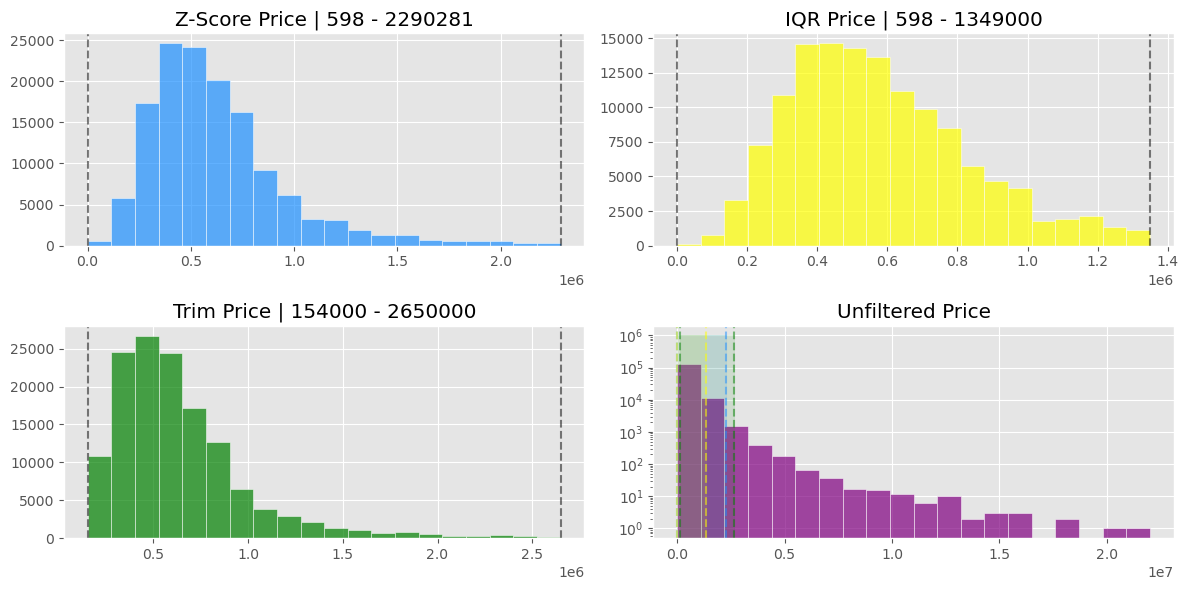

In [103]:
plot_outlier_methods(df, "price", iscont=True)
plt.show()

<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Outliers - Area</strong>
</div>

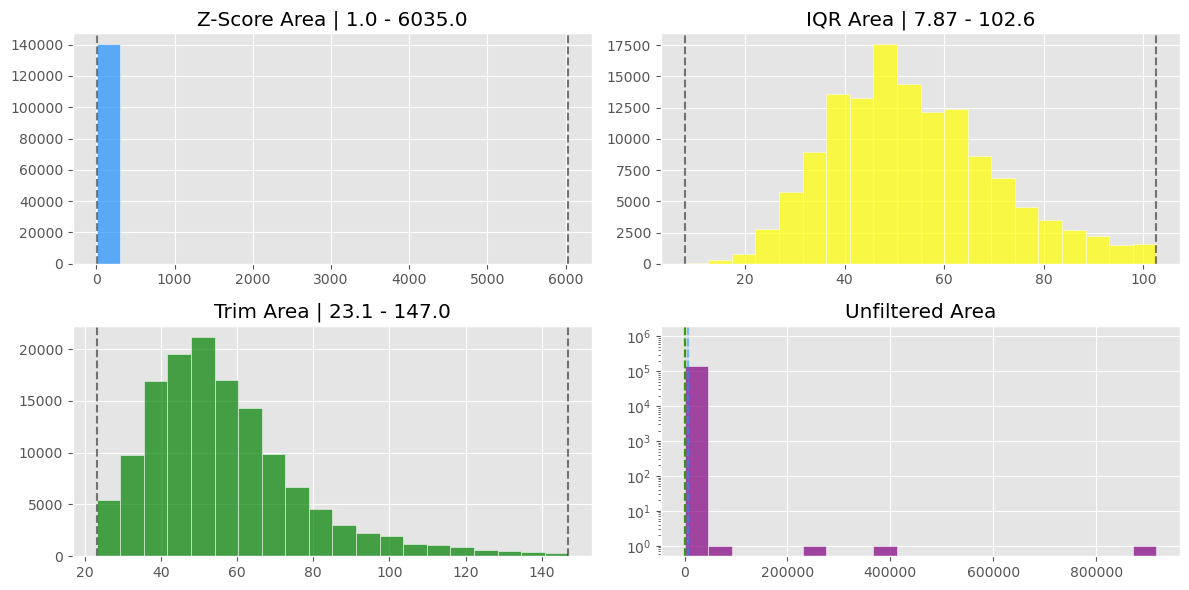

In [105]:
plot_outlier_methods(df, "area", iscont=True)
plt.show()

<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Outliers - Floor Total Number</strong>
</div>

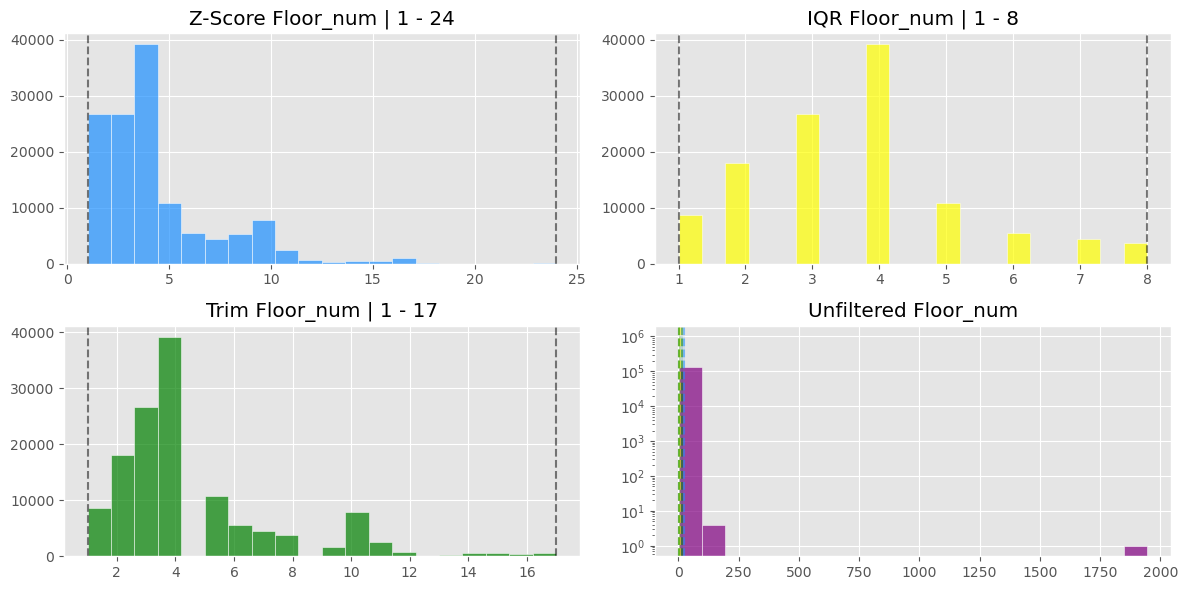

In [107]:
plot_outlier_methods(df, "floor_num")
plt.show()

<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Outliers - Build Year</strong>
</div>

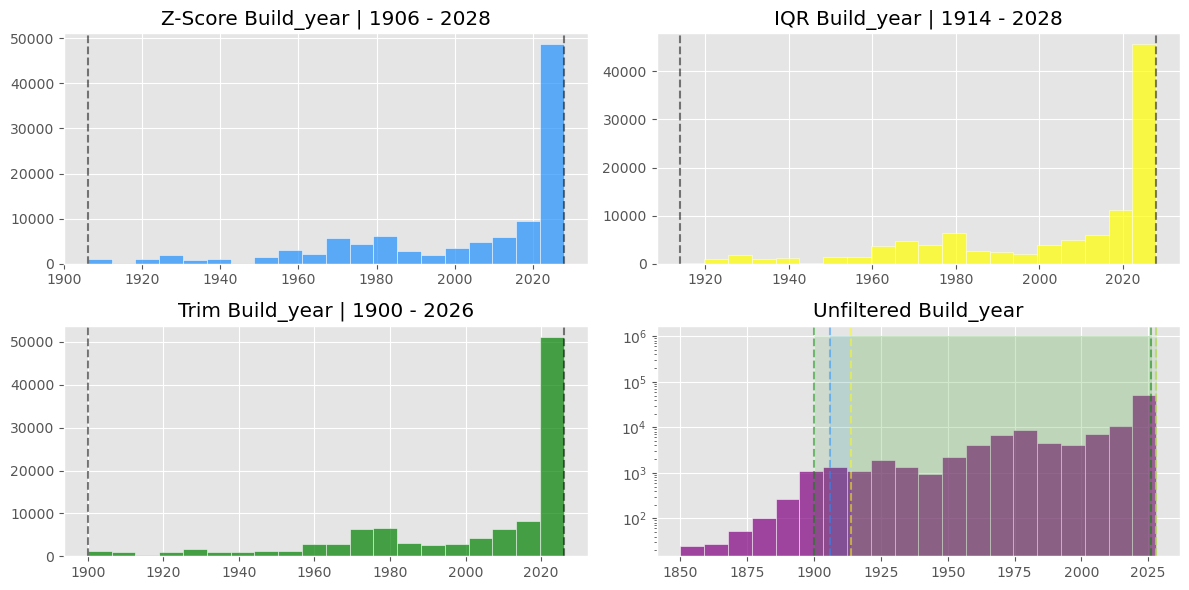

In [117]:
plot_outlier_methods(df, "build_year", bounds=(1850, 2030))
plt.show()

<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Pipeline definition</strong>
</div>

In [109]:
df[df["floor_num"].between("1", "17")]["floor_num"].value_counts()

floor_num
1      8681
10     7853
11     2528
12      690
14      556
17      519
15      497
16      466
13      272
101       1
100       1
111       1
102       1
Name: count, dtype: int64

In [97]:
class FilterOutliers:

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def floor_num(self):
        if not self.df["floor_num"].dtype == "O":
            self.df["floor_num"] = self.df["floor_num"].astype(str)
        f_arg = (self.df["floor_num"].between("1", "17")) | (self.df["floor_num"].isna())
        num_deleted = len(np.where(f_arg == False)[0])
        self.df = self.df[f_arg]
        print("floor_num: ", num_deleted)
        return self

    def price(self):
        f_arg = self.df["price"].between(154_000, 3_000_000)
        num_deleted = len(np.where(f_arg == False)[0])
        self.df = self.df[f_arg]
        print("price: ", num_deleted)
        return self

    def area(self):
        f_arg = self.df["area"].between(23, 150)
        num_deleted = len(np.where(f_arg == False)[0])
        self.df = self.df[f_arg]
        print("area: ", num_deleted)
        return self

    def build_year(self):
        f_arg = (self.df["build_year"].between("1900", "2028")) | (self.df["build_year"].isna())
        num_deleted = len(np.where(f_arg == False)[0])
        self.df = self.df[f_arg]
        print("build_year: ", num_deleted)
        return self

    def run(self) -> pd.DataFrame:
        return (
            self.floor_num()
            .price()
            .area()
            .build_year()
            .df
        )

In [99]:
pipeline_outliers = FilterOutliers(df)
dff = pipeline_outliers.run()

floor_num:  111218
price:  612
area:  423
build_year:  108


In [43]:
df.shape

(140314, 21)

In [45]:
dff.shape

(27953, 21)